In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pickle
from scipy.ndimage.measurements import label
import random

## Training the Model

#### Spatial Binning

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    #feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #S=feature_image[:,:,2]
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

#### Color Histogram Features

In [4]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#### HOG Features

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Extracting HOG Features

In [54]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 1), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        #image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(file, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(file, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(file, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(file, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(file, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(file)      
        # Apply bin_spatial() to get spatial color features
        #spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        #hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Apply get_hog_features() for extracting HOG features
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        #features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        features.append(hog_features)
    # Return list of feature vectors
    return features


# Read in car and non-car images
images_car = glob.glob('vehicles/*/*.png')
images_notcar = glob.glob('non-vehicles/*/*.png')
cars = []
notcars = []
for image in images_car:
    readImage=cv2.imread(image)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    cars.append(rgbImage)
for image in images_notcar:
    readImage=cv2.imread(image)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    notcars.append(rgbImage)

print(len(cars))
print(len(notcars))


### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 16
histbin = 16

car_features = extract_features(cars, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 255),orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 255),orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

obj_pickle = {}
obj_pickle["X_scaler"] = X_scaler
obj_pickle["X_train"] = X_train
obj_pickle["X_test"] = X_test
obj_pickle["y_train"] = y_train
obj_pickle["y_test"] = y_test
pickle.dump( obj_pickle, open( "features_pickle.p", "wb" ) )


print('Feature vector length:', len(X_train[0]))

8792
8968
Feature vector length: 1188


### Training the Model using SVM 

In [55]:
# Use a SVC with RBF Kernel

svc = svm.SVC(kernel='rbf')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

pickle.dump( svc, open( "svc.p", "wb" ) )
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

52.56 Seconds to train SVC...
Test Accuracy of SVC =  0.9868
My SVC predicts:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
0.0625 Seconds to predict 10 labels with SVC


## Pipeline

#### Sliding windows

In [3]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    ## Finding first list of windows

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
      
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        #print(len(window_list))
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    
    return window_list



#### Draw Box

In [4]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        color=(r, g, b)
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#### Single Image features extraction

In [5]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

#### Search Window

In [6]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 1), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over First windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))

        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))

        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction[0] == 1:
            on_windows.append(window)       
    return on_windows
    

In [7]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        ## Logic to remove windows in which vertical length of box is greater than 1.5*horizontal_length
        if ((np.max(nonzeroy)-np.min(nonzeroy))>=1.5*(np.max(nonzerox)-np.min(nonzerox))):
            continue
        
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 4)
    # Return the image
    return img

In [8]:
## Class to detect data from Video

class Detect_Vehicle():
    
    def __init__(self):
        ## Previous detected frames
        self.prev_rects=[]
    
    def add_rects(self,rects):
        self.prev_rects.append(rects)
        
        if len(self.prev_rects)>15:
            self.prev_rects=self.prev_rects[len(self.prev_rects)-15:]

In [9]:
## Loading Pickles file
pickle_file = 'features_pickle.p'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_scaler_norm = pickle_data['X_scaler']
        
pickle_file_svc = 'svc.p'
with open(pickle_file_svc, 'rb') as f:
    pickle_data = pickle.load(f)
    svc = pickle_data


Total No of windows are  250
Total No. of hot windows  25


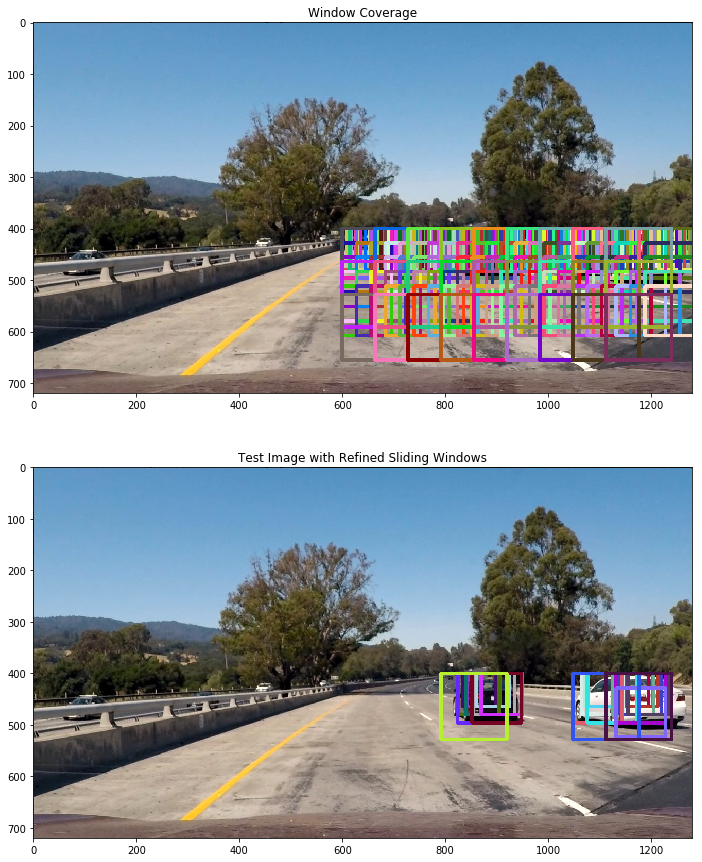

In [10]:
## Slide Windows sizes

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb'   # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11             # HOG orientations
pix_per_cell = 16       # HOG pixels per cell
cell_per_block = 2      # HOG cells per block
hog_channel = "ALL"     # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16          # Number of histogram bins
spatial_feat = False    # Spatial features on or off
hist_feat = False       # Histogram features on or off
hog_feat = True         # HOG features on or off
    
    

image = mpimg.imread('test_images/test1.jpg')

windows1 = slide_window(image, x_start_stop=[600, 1300], y_start_stop=[400, 464],xy_window=(64, 64), xy_overlap=(0.85, 0.85))
windows2 = slide_window(image, x_start_stop=[600, 1300], y_start_stop=[400, 480],xy_window=(80, 80), xy_overlap=(0.8, 0.8))
windows3 = slide_window(image, x_start_stop=[600, 1300], y_start_stop=[400, 612],xy_window=(96, 96), xy_overlap=(0.7, 0.7))
windows4 = slide_window(image, x_start_stop=[600, 1300], y_start_stop=[400, 660],xy_window=(128, 128), xy_overlap=(0.5, 0.5))
    
windows = windows1 + windows2 +  windows3 + windows4
print("Total No of windows are ",len(windows))

#image = image.astype(np.float32)/255

refinedWindows=search_windows(image, windows, svc, X_scaler_norm, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                 orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print("Total No. of hot windows ",len(refinedWindows))
f,axes= plt.subplots(2,1, figsize=(30,15))

window_img = draw_boxes(image, windows) 

axes[0].imshow(window_img)
axes[0].set_title("Window Coverage")

window_img = draw_boxes(image, refinedWindows) 

axes[1].set_title("Test Image with Refined Sliding Windows")
axes[1].imshow(window_img)


In [30]:
## Final Pipeline to detect bounding box on vehicle

det = Detect_Vehicle()

def Pipeline(image):
    
    draw_image = np.copy(image)
    
    plt.imsave(image_path+str(count)+'O'+'.jpg', image)
    
    hot_windows = search_windows(image, windows, svc, X_scaler_norm, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                 orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=5)                    
    
    # add detections to the history
    if len(hot_windows) > 0:
        det.add_rects(hot_windows)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for rect_set in det.prev_rects:
        #Add heat to each box in box list
        heat = add_heat(heat, rect_set)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,25 + len(det.prev_rects)//2) 
    
    # Visualize the heatmap when displaying
    #clip(a, a_min, a_max, out=None)
    #Given an interval, values outside the interval are clipped to the interval edges.
    #For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.
    heatmap = np.clip(heat, 0, 255)    
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(image, labels)
    
    return draw_img

test_image = mpimg.imread('test_images/test1.jpg')

draw_img=Pipeline(test_image)



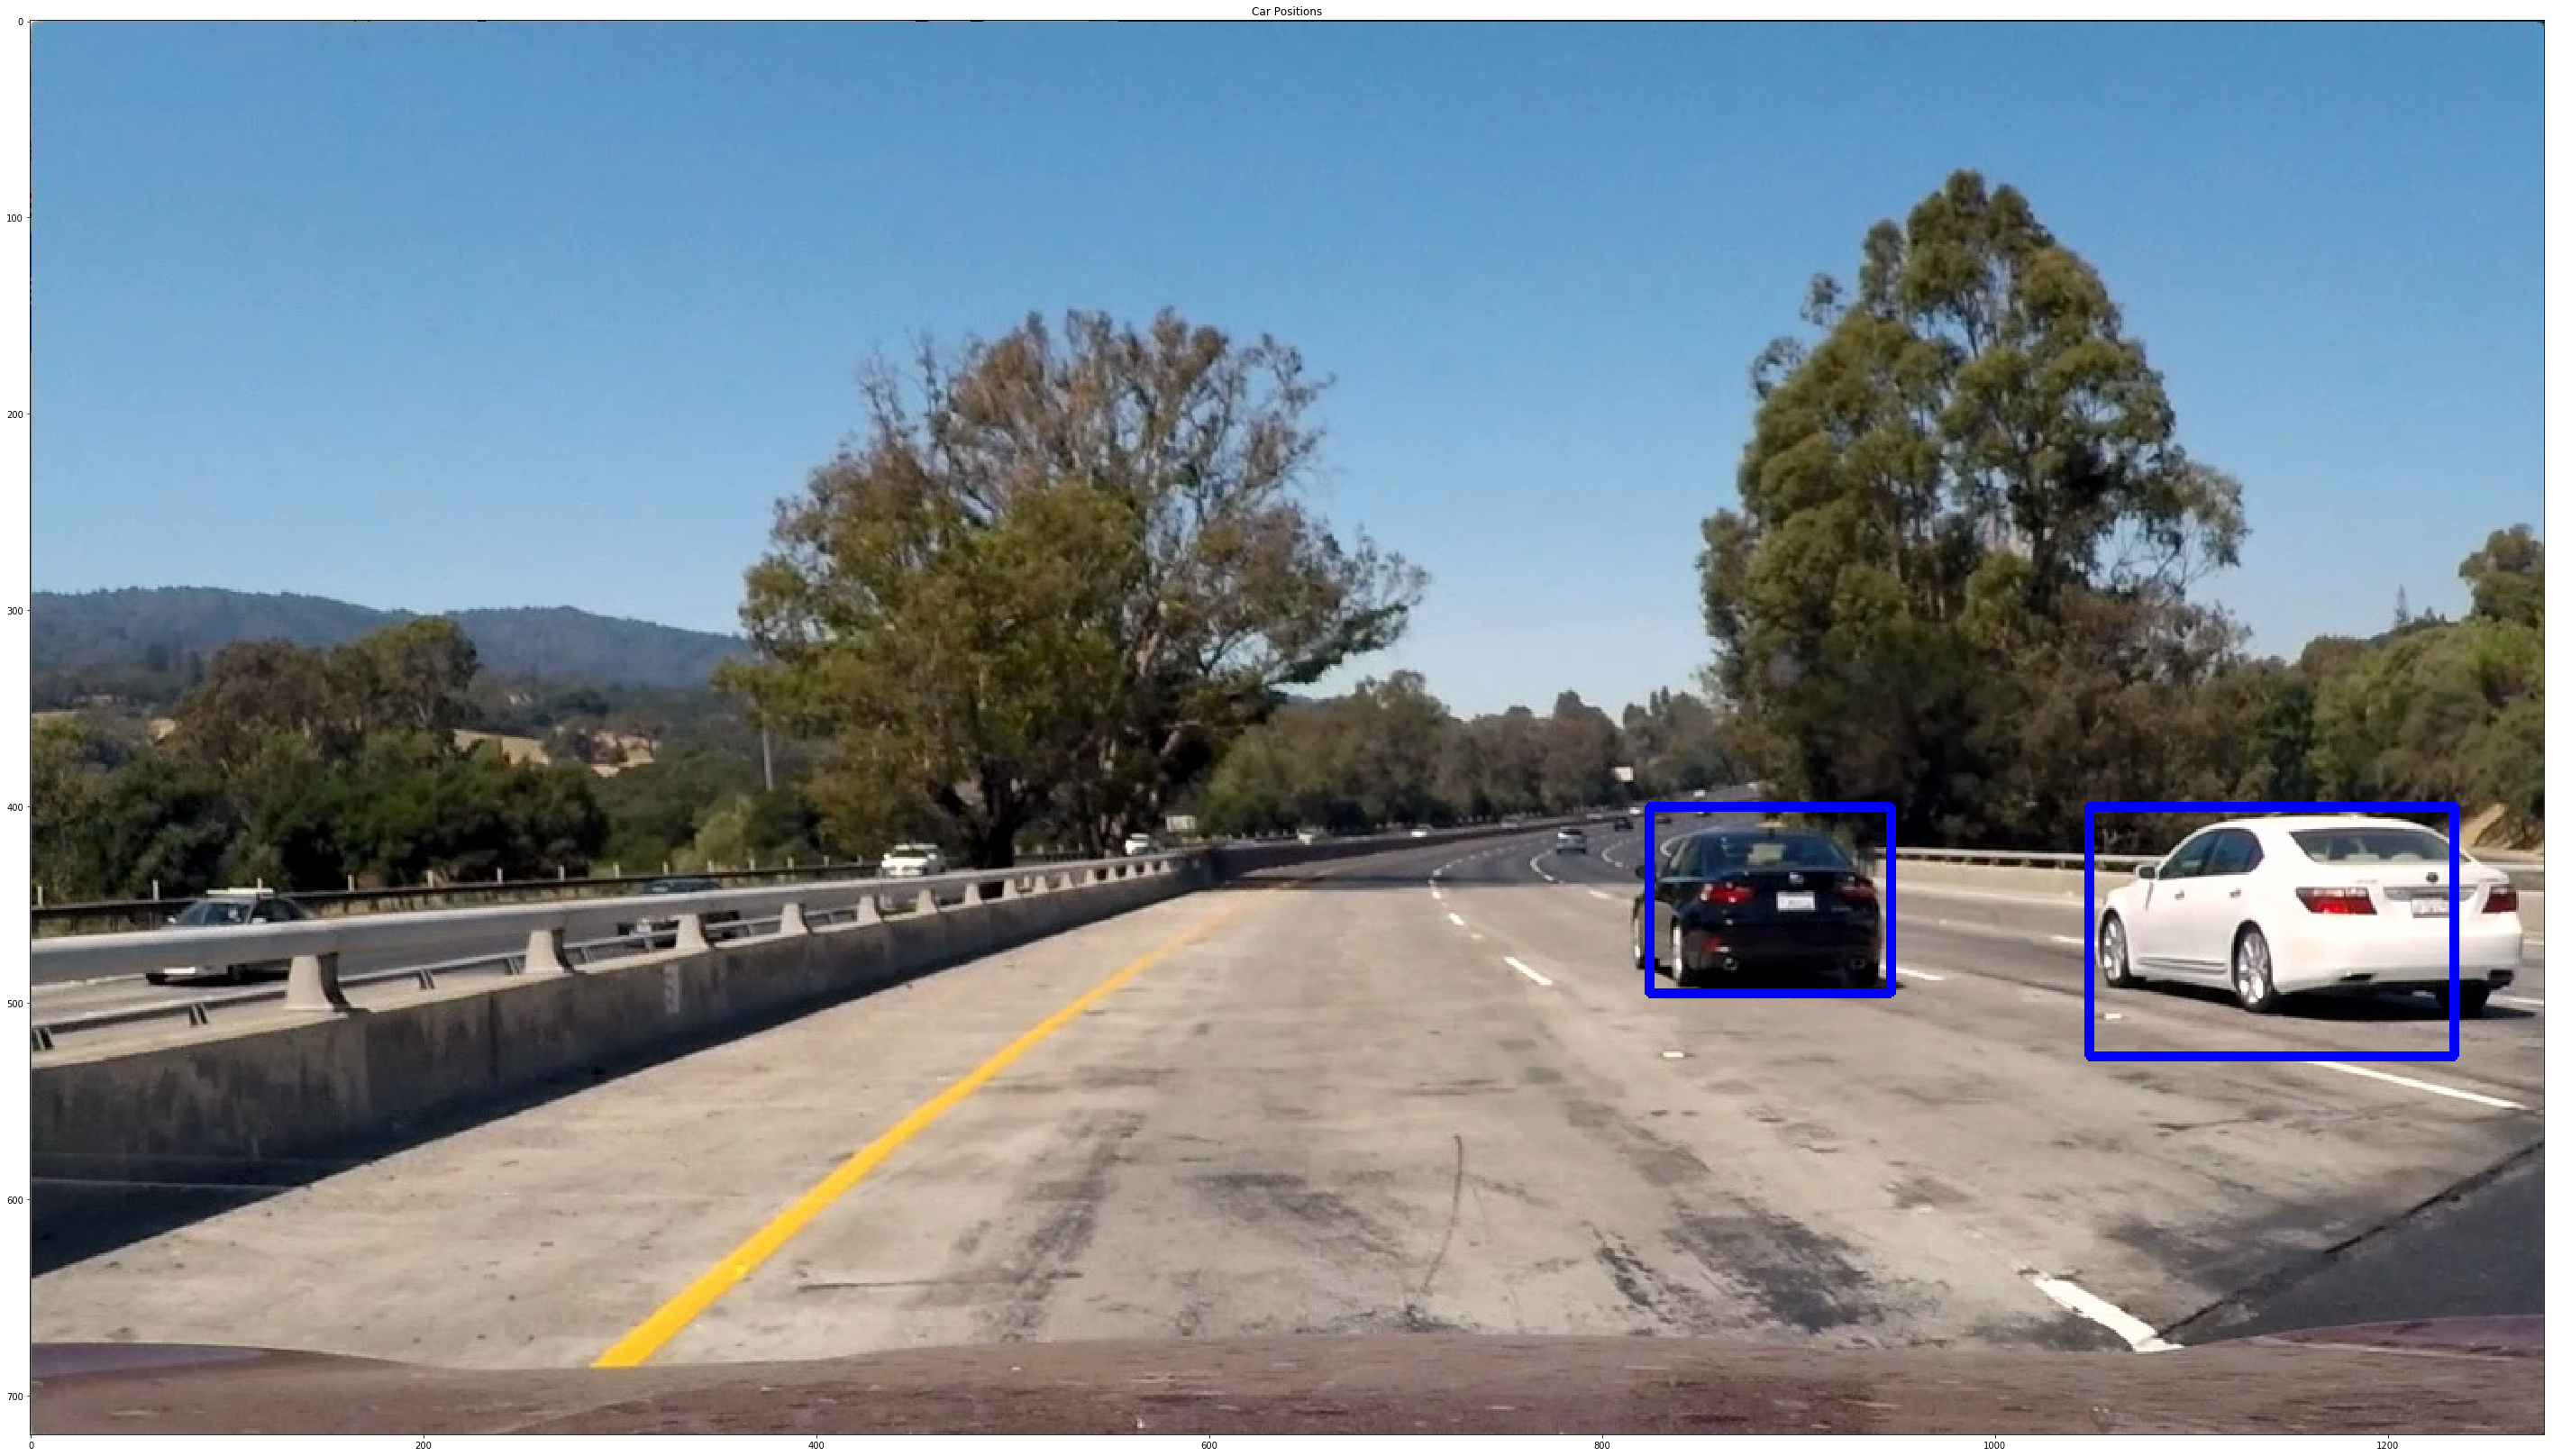

In [31]:
fig = plt.figure(figsize=(50,100))
plt.imshow(draw_img)
plt.title('Car Positions')

In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

det = Detect_Vehicle()
global count

count=0
white_output = 'project_video_output_full_25_thres.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(Pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output_full_25_thres.mp4
[MoviePy] Writing video project_video_output_full_25_thres.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:15:02<00:03,  3.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_full_25_thres.mp4 

Wall time: 1h 15min 5s
